In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Load a cleaned set of edit conflicts which excludes the following sets:
1. all conflicts caused by known or suspected interface bugs (), and
1. "undebounced" duplicate conflicts logged at the same timestamp.

In [44]:
conflicts = spark.read.parquet("/tmp/awight/clean_conflicts").cache()
total_count = conflicts.count()
total_count

1939

Where are conflicts happening?  On all wikis?

TODO:
* namespace pie
* scatterplot of wiki edit activity x rate of conflicts.  dot size is ~ wiki size

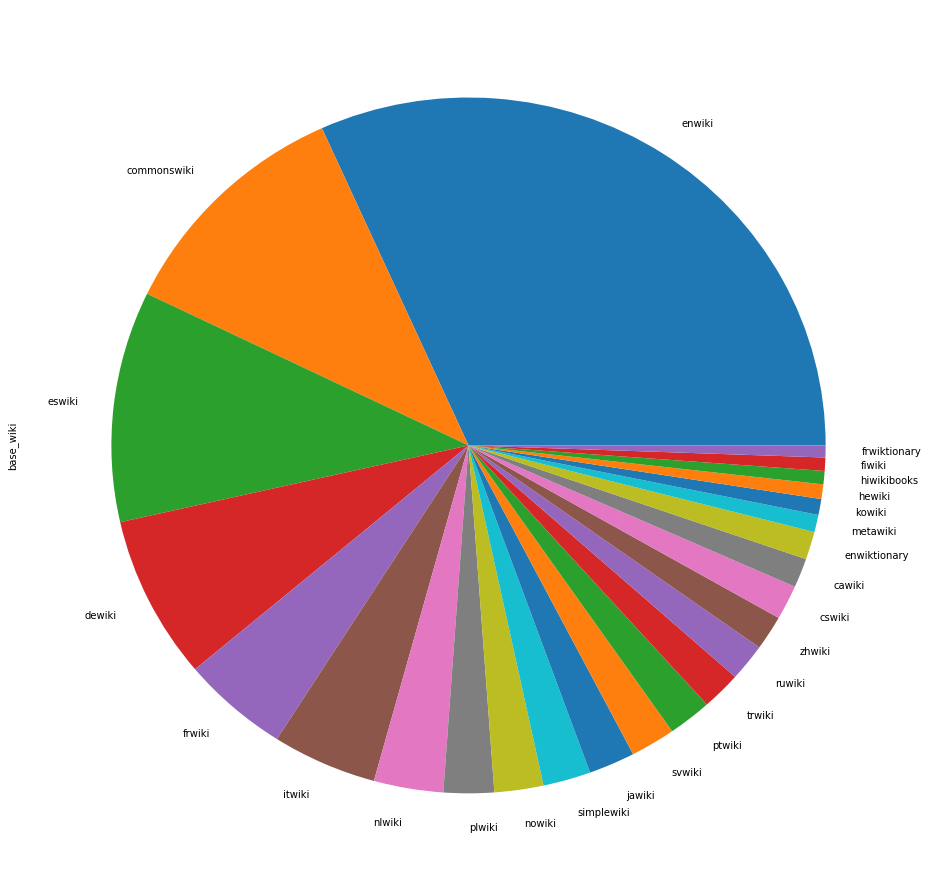

In [5]:
c = conflicts.toPandas()
c['base_wiki'].value_counts()[0:25].plot.pie(figsize=(16,16))

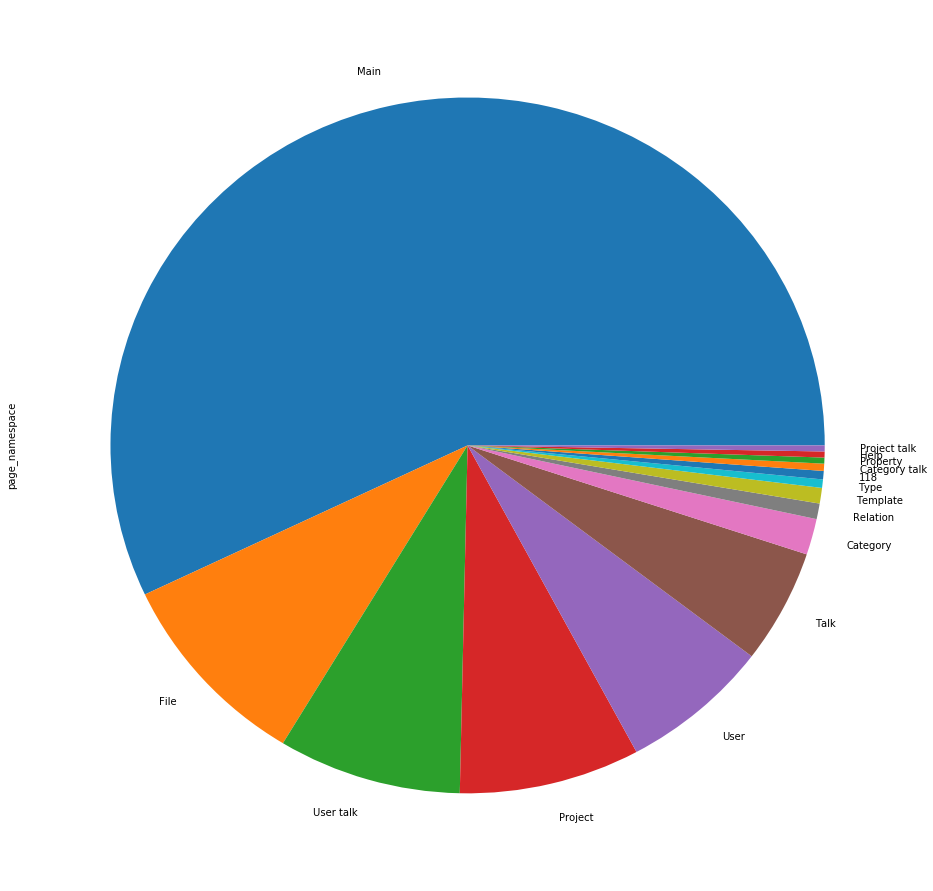

In [40]:
namespace_lookup = {
    0: 'Main',
    1: 'Talk',
    2: 'User',
    3: 'User talk',
    4: 'Project',
    5: 'Project talk',
    6: 'File',
    7: 'File talk',
    10: 'Template',
    12: 'Help',
    14: 'Category',
    15: 'Category talk',
    100: 'Relation',
    102: 'Property',
    104: 'Type',
}

c['page_namespace'].dropna().astype(int).apply(lambda id: namespace_lookup[id] if id in namespace_lookup else id).value_counts()[0:15].plot.pie(figsize=(16,16))

## Edit spacing in time
Are conflicting edits usually close together in time?  Is the page being editing very actively, in which case the base and other revisions would be very recent?  Is the base revision old, and the other and conflicting edits are close together?

TODO:
* Gather "starttime" metrics to see how long the editor spent on the edit page.

In [6]:
ages = pd.DataFrame(
    data={
        'base_age': (c['conflict_timestamp'] - c['base_timestamp']) / pd.Timedelta(1, unit='s'),
        'other_age': (c['conflict_timestamp'] - c['other_timestamp']) / pd.Timedelta(1, unit='s')
    }
)

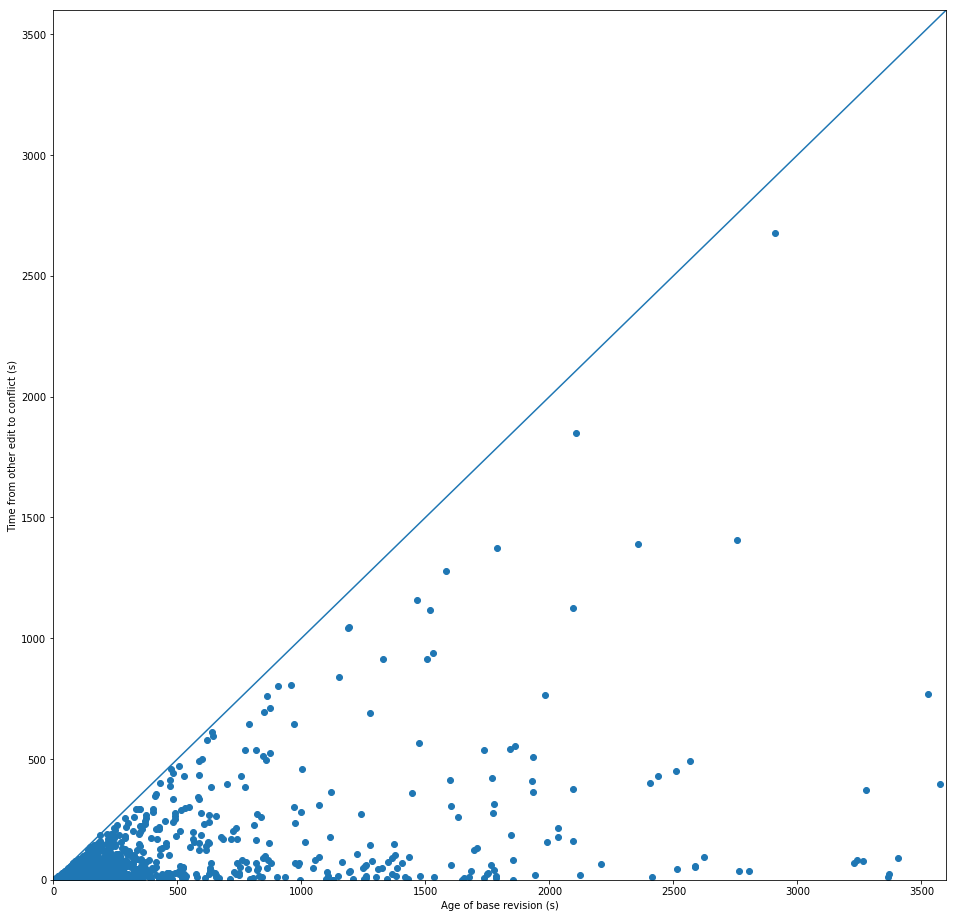

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 16)
ax.scatter(ages.base_age, ages.other_age)
ax.plot([0, 3600], [0, 3600])
ax.set_xlim(0, 3600)
ax.set_ylim(0, 3600)
ax.set_xlabel('Age of base revision (s)')
ax.set_ylabel('Time from other edit to conflict (s)')
plt.show()

In [8]:
relative_ages = pd.Series(
    data=ages.other_age / ages.base_age
).dropna()

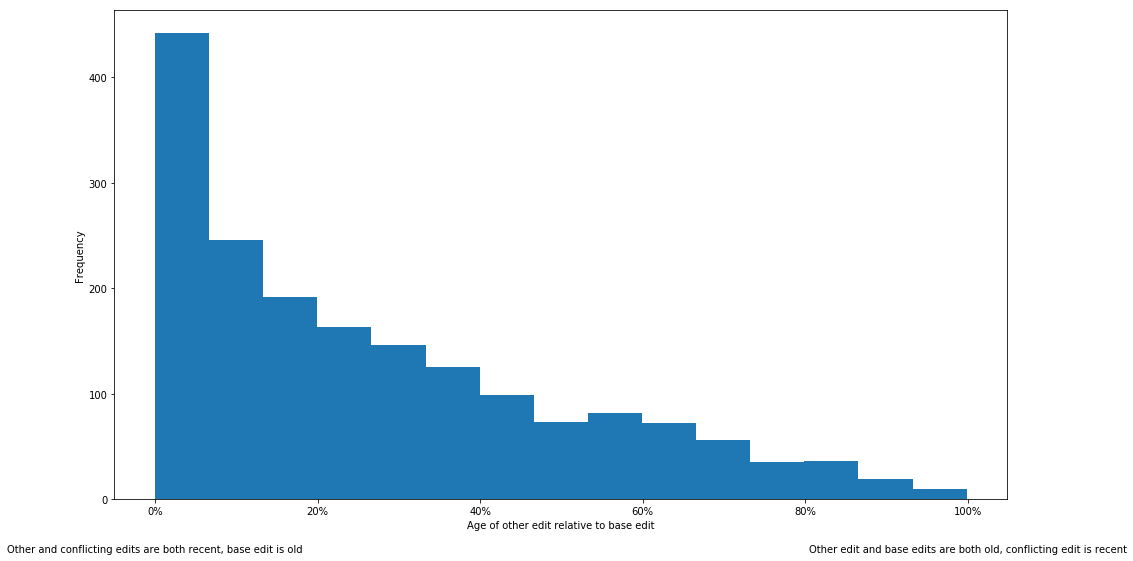

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.hist(relative_ages, 15)
ax.set_xlabel('Age of other edit relative to base edit')
ax.set_ylabel('Frequency')
ax.text(0, -50, 'Other and conflicting edits are both recent, base edit is old', ha='center')
ax.text(1, -50, 'Other edit and base edits are both old, conflicting edit is recent', ha='center')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

## Double conflicts

How often do conflicts pile up due to rapid editing?  In other words, is it common to experience a second edit conflict when trying to save the results of resolving the first?

In this case, the baseRevisionId of one conflict would be the latestRevisionId of a previous conflict.  Searching for those is a good start.

In [52]:
from pyspark.sql.functions import col

double_conflicts = conflicts.alias("first_conflict").join(
    conflicts.alias("second_conflict"),
    (col("first_conflict.wiki") == col("second_conflict.wiki"))
        & (col("first_conflict.latestRevisionId") == col("second_conflict.baseRevisionId"))
        # FIXME: Only slightly better than nothing to correlate the user...
        & (col("first_conflict.browser_family") == col("second_conflict.browser_family"))
)

print("{}, or {:.0%} of total".format(double_conflicts.count(), double_conflicts.count() / total_count))

110, or 6% of total


So, what are these?

In [26]:
double_conflicts.groupBy(["first_conflict.wiki", "first_conflict.page_title"]).count().sort("count", ascending=False).show(n=20, truncate=False)

+------------+-------------------------------------------------------------+-----+
|wiki        |page_title                                                   |count|
+------------+-------------------------------------------------------------+-----+
|enwiki      |User:M.hin.ck/sandbox                                        |15   |
|enwiki      |User_talk:King_Mythical_Tiger                                |8    |
|eswiki      |Usuario_discusión:80.32.15.88                                |7    |
|enwiktionary|Gilgameshian                                                 |4    |
|ltwiki      |Bušmėnai                                                     |3    |
|nowiki      |Steinalderen                                                 |3    |
|enwiki      |Wikipedia:Edit_filter/False_positives/Reports                |3    |
|simplewiki  |User_talk:80.194.200.53                                      |3    |
|enwiki      |Ezra_Furman_and_the_Harpoons                                 |2    |
|sqw

This [first sandbox page](https://en.wikipedia.org/w/index.php?title=User:M.hin.ck/sandbox&action=history) is interesting, it looks like a WikiEdu class held a lively editathon, with lots of conflicts.  They had a rough time of it:

In [29]:
fun_sandbox = conflicts.filter(
    (col("wiki") == "enwiki")
    & (col("page_title") == 'User:M.hin.ck/sandbox')
)
fun_sandbox.count()

16

## Diffs
Play with a transformation to display each diff composing a conflict.  We do have raw "your text" recorded in events, but TODO don't yet have a convenient way to diff it against other revisions.  Overall, this makes the chart less useful than I'd hoped.

In [30]:
from pyspark.sql.functions import concat, lit

def makeDiffLinks(rev_id_column, parent_rev_id_column=None):
    global conflicts
    terms = [
        lit("https://"),
        conflicts.webhost,
        lit("/wiki/?diff="),
        rev_id_column
    ]
    if parent_rev_id_column is not None:
        terms.extend([
            lit("&oldid="),
            parent_rev_id_column
        ])
    return concat(*terms)


def makeDiffAnchors(title, rev_id_column, parent_rev_id_column=None):
    return concat(
        lit("<a href=\""),
        makeDiffLinks(rev_id_column, parent_rev_id_column),
        lit("\">{}</a>".format(title))
    )


#diff_links = conflicts.select(
#    makeDiffAnchor("->B", conflicts.baseRevisionId).alias("base_diff"),
#    makeDiffAnchor("B->O", conflicts.other_rev_id, conflicts.baseRevisionId).alias("other_base_diff"),
#    makeDiffAnchor("O->N", conflicts.next_rev_id, conflicts.other_rev_id).alias("other_next_diff"),
#)
#from IPython.display import HTML
#HTML(diff_links.toPandas().head(10).to_html(escape=False))


diff_links = conflicts.select(
    makeDiffLinks(conflicts.baseRevisionId).alias("base_diff"),
    makeDiffLinks(conflicts.other_rev_id, conflicts.baseRevisionId).alias("other_base_diff"),
    makeDiffLinks(conflicts.next_rev_id, conflicts.other_rev_id).alias("other_next_diff"),
)

pd.set_option('display.max_colwidth', -1)
diff_links.toPandas().head(10)

,base_diff,other_base_diff,other_next_diff
0,https://bn.wikipedia.org/wiki/?diff=3969639,https://bn.wikipedia.org/wiki/?diff=3971652&oldid=3969639,https://bn.wikipedia.org/wiki/?diff=3971657&oldid=3971652
1,https://ru.wikipedia.org/wiki/?diff=105273228,https://ru.wikipedia.org/wiki/?diff=105273480&oldid=105273228,https://ru.wikipedia.org/wiki/?diff=105273499&oldid=105273480
2,https://fr.wikipedia.org/wiki/?diff=167074031,https://fr.wikipedia.org/wiki/?diff=167074054&oldid=167074031,https://fr.wikipedia.org/wiki/?diff=167074153&oldid=167074054
3,https://en.wikipedia.org/wiki/?diff=942942827,https://en.wikipedia.org/wiki/?diff=942943219&oldid=942942827,https://en.wikipedia.org/wiki/?diff=942943677&oldid=942943219
4,https://commons.wikimedia.org/wiki/?diff=395536869,https://commons.wikimedia.org/wiki/?diff=395537127&oldid=395536869,https://commons.wikimedia.org/wiki/?diff=395537670&oldid=395537127
5,https://commons.wikimedia.org/wiki/?diff=396786755,https://commons.wikimedia.org/wiki/?diff=396788806&oldid=396786755,https://commons.wikimedia.org/wiki/?diff=396790858&oldid=396788806
6,https://de.wikipedia.org/wiki/?diff=197232972,https://de.wikipedia.org/wiki/?diff=197234113&oldid=197232972,https://de.wikipedia.org/wiki/?diff=197234131&oldid=197234113
7,https://it.wikipedia.org/wiki/?diff=110995369,https://it.wikipedia.org/wiki/?diff=110995377&oldid=110995369,https://it.wikipedia.org/wiki/?diff=110995395&oldid=110995377
8,https://no.wikipedia.org/wiki/?diff=20179675,https://no.wikipedia.org/wiki/?diff=20179680&oldid=20179675,None
9,https://en.wikipedia.org/wiki/?diff=942896675,https://en.wikipedia.org/wiki/?diff=942896725&oldid=942896675,https://en.wikipedia.org/wiki/?diff=942896781&oldid=942896725


## Self-conflicts

In [51]:
self_conflicts = conflicts.filter(
    conflicts.other_user == conflicts.next_user)
print("{}, or {:.0%} of total".format(self_conflicts.count(), self_conflicts.count() / total_count))

316, or 16% of total


That's a lot of self-conflicts.  We should look at why this is happening.

## Hot pages
Which pages experience the most conflicts?

In [62]:
conflicts\
    .filter(conflicts.page_id.isNotNull())\
    .groupBy("wiki", "page_title")\
    .count().sort("count", ascending=False)\
    .show(n=20, truncate=False)

+-----------+--------------------------------------+-----+
|wiki       |page_title                            |count|
+-----------+--------------------------------------+-----+
|enwiki     |Wikipedia:Sandbox                     |36   |
|eswiki     |Usuario_discusión:80.32.15.88         |17   |
|enwiki     |User:M.hin.ck/sandbox                 |16   |
|itwiki     |Wikipedia:Pagina_delle_prove          |15   |
|ruwiki     |Википедия:Песочница                   |13   |
|enwiki     |User_talk:King_Mythical_Tiger         |12   |
|eswiki     |Wikipedia:Zona_de_pruebas/1           |9    |
|dewiki     |Wikipedia:Spielwiese                  |9    |
|hiwikibooks|भारत_के_स्मारक                        |9    |
|frwiki     |Utilisateur:Thib95                    |8    |
|enwiki     |User:Adamw/sandbox                    |7    |
|simplewiki |Danville,_Iowa                        |7    |
|eswiki     |Distorted_Emerald                     |6    |
|ptwiki     |1_redes_EEEP_Maria_Altair             |6   